This notebook uses https://nextjournal.com/gkoehler/pytorch-mnist as a basis to
apply federated learning concepts.

Let's start with importing some necessary modules

In [1]:
import torch
import torchvision
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

And define our main variables

In [2]:
user_count = 10
user_fraction = 0.3
c_epochs = 52  # central epochs
c_rate = 0.5  # central learning rate (relevant if fed_svg == True)
learning_rate = 0.01  # local
momentum = 0.5  # local
fed_sgd = True  # use fed_avg when False
local_epochs = 10 # relevant if fed_svg == False

Now, for the network, train and test definitions

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)


def train(network, data, target):
    iterations = 1
    l_epochs = 1
    if not fed_sgd:
        data = torch.split(data, 64)  # split into 64 part batches if using fed_avg
        iterations = len(data)
        print("We got " + str(iterations) + " iterations")
        target = torch.split(target, 64)
        l_epochs = local_epochs
    else:
        data = [data]  # wrap data in an array so that data has always the same nesting count
        target = [target]

    for local_epoch in range(l_epochs):
        for i in range(iterations):
            global train_losses
            optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                                  momentum=momentum)
            network.train()
            optimizer.zero_grad()
            output = network(data[i])
            loss = F.nll_loss(output, target[i])
            loss.backward()
            if not fed_sgd:
                optimizer.step()
                optimizer.zero_grad()
        train_losses.append(loss)
        print(f'Local epoch: {local_epoch}, Batch loss: {loss}')
    if fed_sgd:
        # https://discuss.pytorch.org/t/please-help-how-can-copy-the-gradient-from-net-a-to-net-b/41226/5
        return [param[1].grad for param in network.named_parameters()]
    else:
        return network.state_dict()


def test(network):
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    print('Test set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss

Load up the MNIST Data

In [4]:
batch_size_test = 1000
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)
user_data = []
user_target = []


def train_loader(user_count):
    return torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('/files/', train=True, download=True,
                                   transform=torchvision.transforms.Compose([
                                       torchvision.transforms.ToTensor(),
                                       torchvision.transforms.Normalize(
                                           (0.1307,), (0.3081,))
                                   ])),
        batch_size=60000 // user_count, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('/files/', train=False, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,))
                               ])),
    batch_size=batch_size_test, shuffle=True)


# make sure the data is fully distributed
for batch_idx, (data, target) in enumerate(train_loader(user_count)):
    print('Preparing data for user', batch_idx)
    user_data.append(data)
    user_target.append(target)
print('Data loaded')

Preparing data for user 0
Preparing data for user 1
Preparing data for user 2
Preparing data for user 3
Preparing data for user 4
Preparing data for user 5
Preparing data for user 6
Preparing data for user 7
Preparing data for user 8
Preparing data for user 9
Data loaded


And start training on multiple user networks

In [5]:
active_user_count = int(user_count * user_fraction)
network_list = []
train_losses = []

cn = Net()  # central_network
for user in range(user_count):
    network_list.append(Net())

optimizer = torch.optim.SGD(cn.parameters(), lr=c_rate, momentum=0.5)

test_losses = [test(cn)]

for c_epoch in range(c_epochs):
    print(f'GLOBAL EPOCH {c_epoch}')
    chosen_users = random.sample(range(user_count), active_user_count)
    if fed_sgd:
        for user_number in chosen_users:
            user_net = network_list[user_number]
            user_net.load_state_dict(cn.state_dict())
            print(f'Local user {user_number}: ', end='')
            for cn_param, user_gradient in zip(cn.named_parameters(),
                                               train(user_net, user_data[user_number],
                                                     user_target[user_number])):
                if cn_param[1].grad is not None:
                    cn_param[1].grad += user_gradient.clone() / active_user_count
                else:
                    cn_param[1].grad = user_gradient.clone() / active_user_count
        optimizer.step()
        optimizer.zero_grad()
    else:
        weights = []
        for user_number in chosen_users:
            user_net = network_list[user_number]
            user_net.load_state_dict(cn.state_dict())
            print(f'Local user {user_number}: ', end='')
            user_weight = train(user_net, user_data[user_number],
                                user_target[user_number])
            weights.append(user_weight)
        weights_average = {}
        first_user = True
        for user_weight in weights:
            for (key, value) in user_weight.items():
                if first_user:
                    weights_average[key] = value / active_user_count
                else:
                    weights_average[key] += value / active_user_count
            first_user = False
        cn.load_state_dict(weights_average)
    print(f'Global epoch {c_epoch}: ', end='')
    test_losses.append(test(cn))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Test set: Avg. loss: 2.2994, Accuracy: 1428/10000 (14%)

GLOBAL EPOCH 0
Local user 4: Local epoch: 0, Batch loss: 2.309497117996216
Local user 9: Local epoch: 0, Batch loss: 2.3077046871185303
Local user 3: Local epoch: 0, Batch loss: 2.3094234466552734
Global epoch 0: Test set: Avg. loss: 2.2657, Accuracy: 2865/10000 (29%)

GLOBAL EPOCH 1
Local user 3: Local epoch: 0, Batch loss: 2.2731807231903076
Local user 8: Local epoch: 0, Batch loss: 2.273749828338623
Local user 0: Local epoch: 0, Batch loss: 2.2729954719543457
Global epoch 1: Test set: Avg. loss: 2.2138, Accuracy: 3859/10000 (39%)

GLOBAL EPOCH 2
Local user 7: Local epoch: 0, Batch loss: 2.2321434020996094
Local user 0: Local epoch: 0, Batch loss: 2.231135368347168
Local user 5: Local epoch: 0, Batch loss: 2.231928825378418
Global epoch 2: Test set: Avg. loss: 2.0876, Accuracy: 5852/10000 (59%)

GLOBAL EPOCH 3
Local user 5: Local epoch: 0, Batch loss: 2.1391565799713135
Local user 3: Local epoch: 0, Batch loss: 2.13926124572753

Finally we plot our results

Text(0, 0.5, 'negative log likelihood loss')

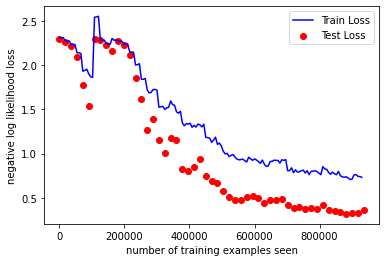

In [10]:
fig = plt.figure()
local_epoch_factor = local_epochs if not fed_sgd else 1
train_counter = [i*(60000 // user_count) for i in range((c_epochs * active_user_count) * local_epoch_factor)]
plt.plot(train_counter, train_losses, color='blue')
test_counter = [i*(60000 // user_count * active_user_count * local_epoch_factor) for i in range(c_epochs + 1)]
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')